In [2]:
import os, re
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from IPython.display import display

# ---------- 0) 한글 폰트 설정 ----------
def setup_korean_font():
    # Colab/Linux에서 Nanum 폰트가 설치돼 있다면 등록
    nanum_dir = "/usr/share/fonts/truetype/nanum"
    if os.path.isdir(nanum_dir):
        for p in fm.findSystemFonts(fontpaths=[nanum_dir], fontext='ttf'):
            fm.fontManager.addfont(p)

    installed = {f.name for f in fm.fontManager.ttflist}
    for name in ["NanumGothic", "Malgun Gothic", "AppleGothic",
                 "Noto Sans CJK KR", "Noto Sans CJK", "NotoSansKR-Regular"]:
        if name in installed:
            mpl.rcParams["font.family"] = name
            break
    mpl.rcParams["axes.unicode_minus"] = False

setup_korean_font()


## Time Interpolation으로 이상치 처리했을 경우 리더보드결과
## 점수 : 7.3603416339


c:\Users\MYNOTE\anaconda3\Lib\site-packages\pandas\core\missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)


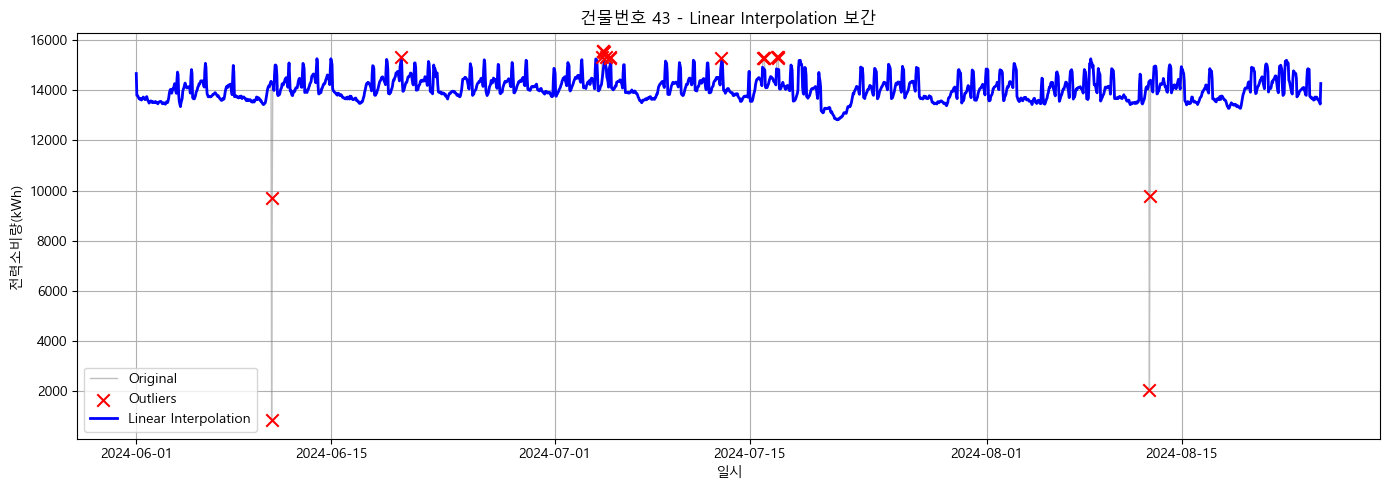

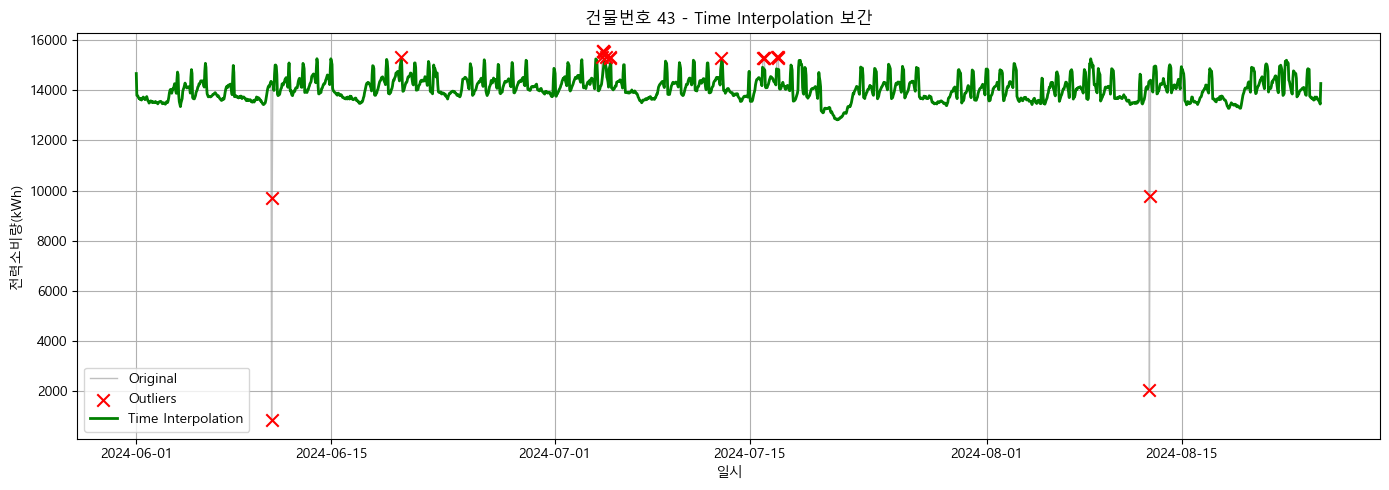

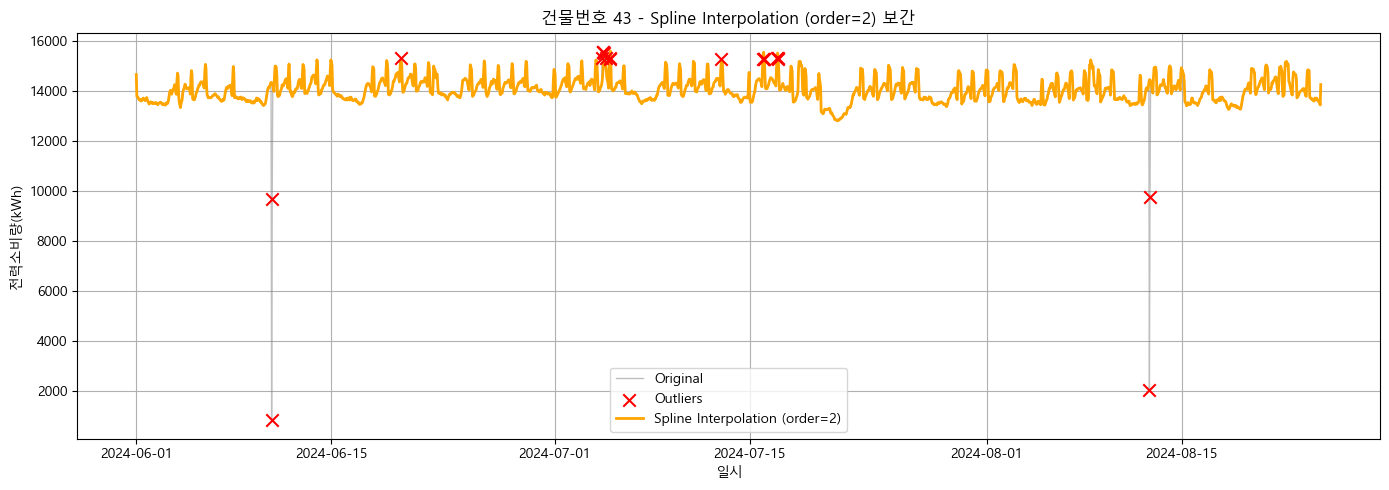

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 로드
train = pd.read_csv("dataset/train.csv")
bi = pd.read_csv("dataset/building_info.csv")

# 2. 병합 및 전처리
merged_df = pd.merge(train, bi[['건물번호', '건물유형']], on='건물번호', how='left')
merged_df['전력소비량(kWh)'] = pd.to_numeric(merged_df['전력소비량(kWh)'], errors='coerce')

# 3. IDC 건물 + datetime 변환
IDC_df = merged_df[merged_df['건물유형'] == 'IDC(전화국)'].copy()
IDC_df['일시'] = pd.to_datetime(IDC_df['일시'], format='%Y%m%d %H', errors='coerce')

# 4. 건물번호 43 추출
building_43 = IDC_df[IDC_df['건물번호'] == 43].sort_values('일시').copy()

# 5. 이상치 탐지 (IQR 기준)
Q1 = building_43['전력소비량(kWh)'].quantile(0.25)
Q3 = building_43['전력소비량(kWh)'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
outlier_mask = (building_43['전력소비량(kWh)'] < lower) | (building_43['전력소비량(kWh)'] > upper)

# 6. 이상치를 NaN으로 마스킹
masked = building_43.copy()
masked.loc[outlier_mask, '전력소비량(kWh)'] = pd.NA

# 7. 보간법별 처리
# Linear
linear_filled = masked.copy()
linear_filled['전력소비량(kWh)'] = linear_filled['전력소비량(kWh)'].interpolate(method='linear')

# Time (requires DatetimeIndex)
time_filled = masked.set_index('일시')
time_filled['전력소비량(kWh)'] = time_filled['전력소비량(kWh)'].interpolate(method='time')
time_filled = time_filled.reset_index()

# Spline
spline_filled = masked.copy()
spline_filled['전력소비량(kWh)'] = spline_filled['전력소비량(kWh)'].interpolate(method='spline', order=2)

# 8. 시각화 함수
def plot_interpolation(df, title, color):
    plt.figure(figsize=(14, 5))
    plt.plot(building_43['일시'], building_43['전력소비량(kWh)'], label='Original', color='gray', linewidth=1, alpha=0.5)
    plt.scatter(building_43['일시'][outlier_mask], building_43['전력소비량(kWh)'][outlier_mask],
                color='red', label='Outliers', marker='x', s=80, zorder=3)
    plt.plot(df['일시'], df['전력소비량(kWh)'], label=title, color=color, linewidth=2)
    plt.title(f"건물번호 43 - {title} 보간")
    plt.xlabel("일시")
    plt.ylabel("전력소비량(kWh)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 9. 보간별 시각화 개별 출력
plot_interpolation(linear_filled, "Linear Interpolation", "blue")
plot_interpolation(time_filled, "Time Interpolation", "green")
plot_interpolation(spline_filled, "Spline Interpolation (order=2)", "orange")


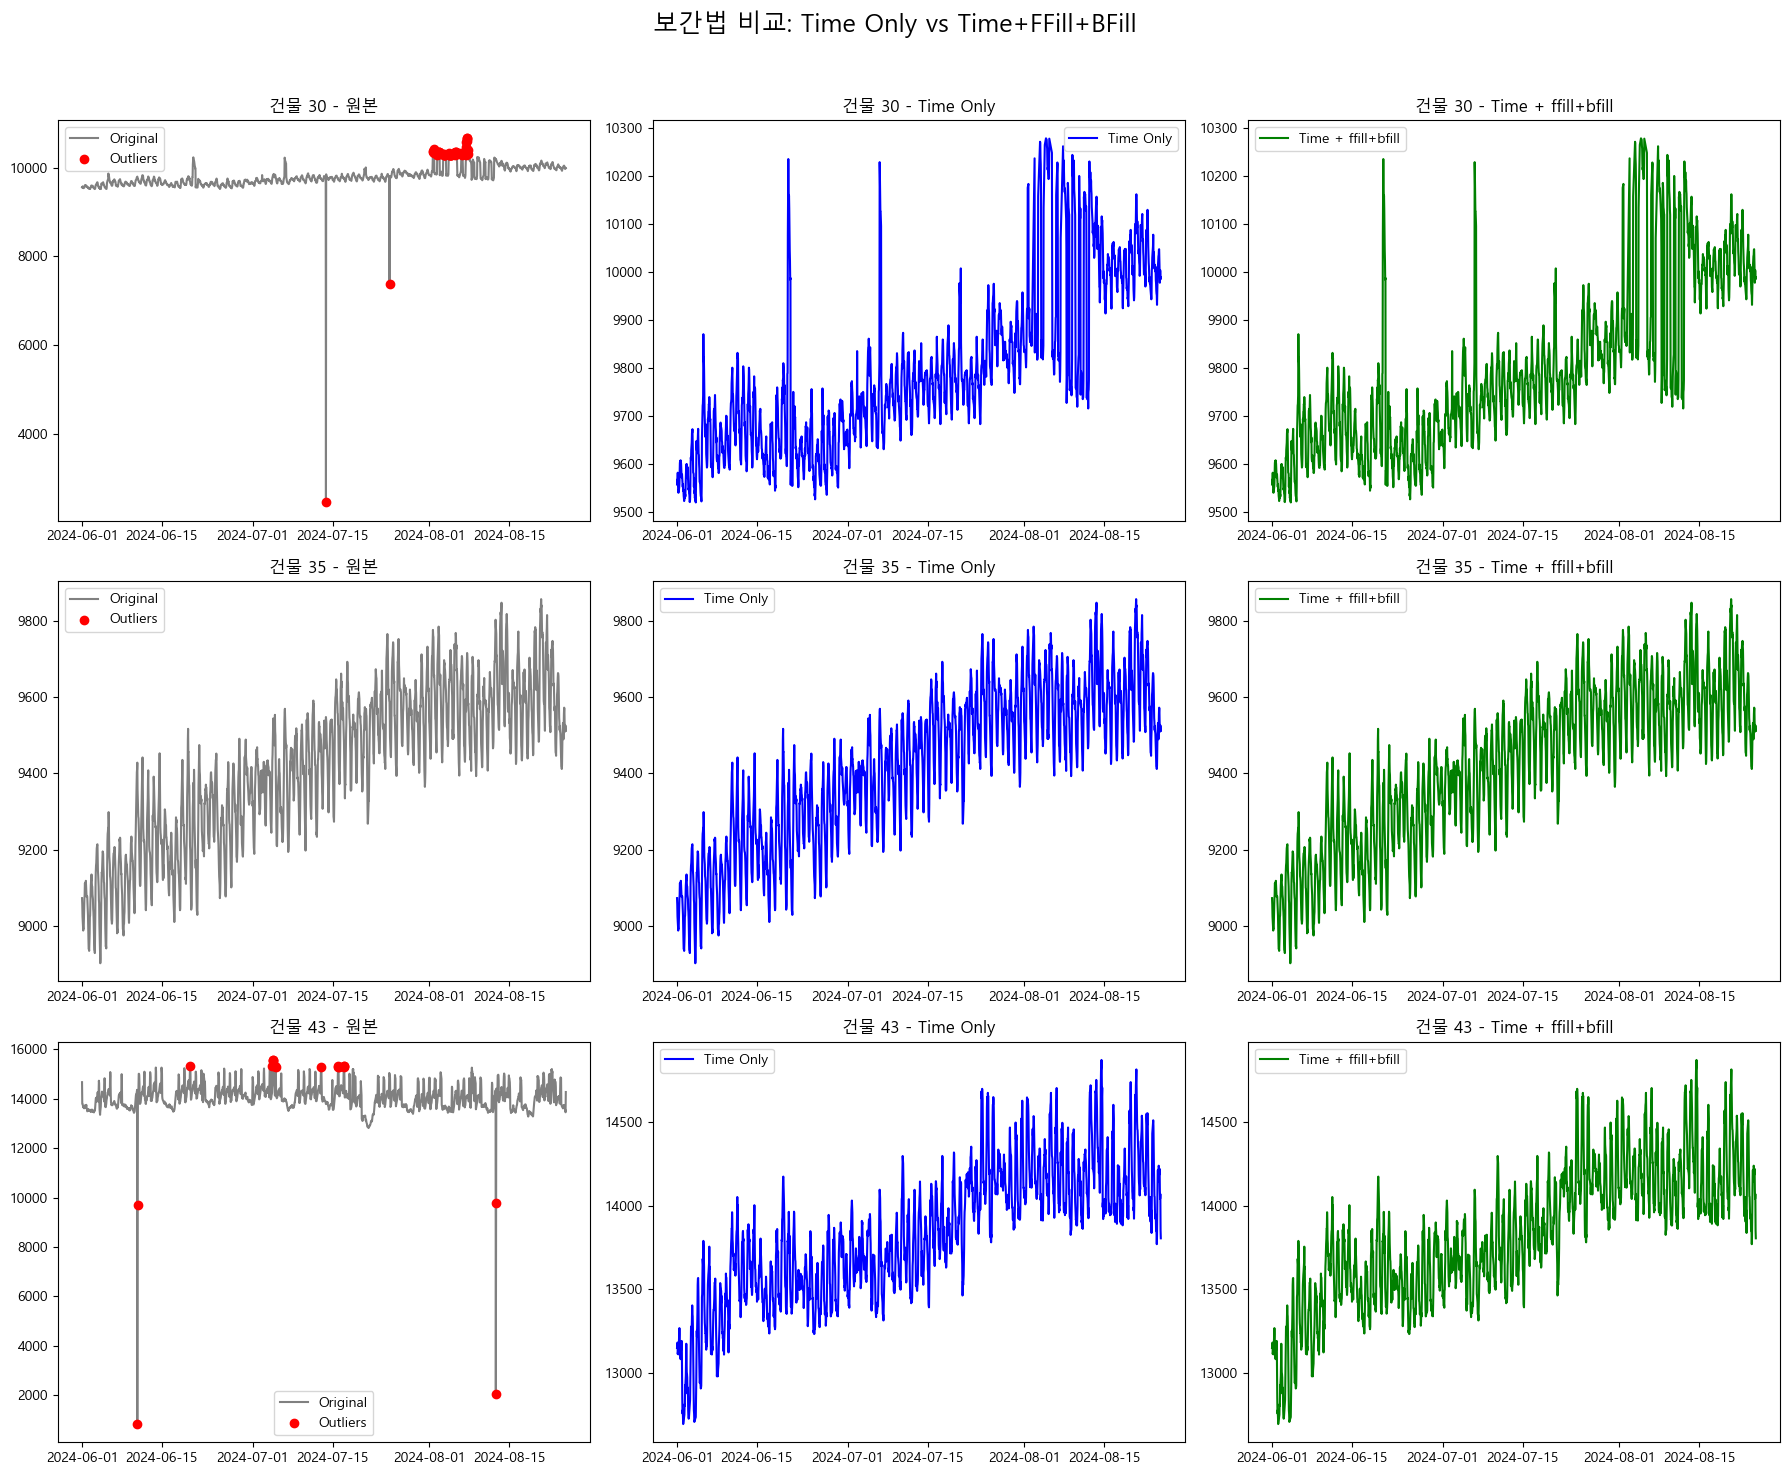

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 병합
train = pd.read_csv('dataset/train.csv', encoding='utf-8')
bi = pd.read_csv('dataset/building_info.csv', encoding='utf-8')
merged_df = pd.merge(train, bi[['건물번호', '건물유형']], on='건물번호', how='left')
merged_df['전력소비량(kWh)'] = pd.to_numeric(merged_df['전력소비량(kWh)'], errors='coerce')

# 2. IDC 건물 필터 및 datetime 변환
IDC_df = merged_df[merged_df['건물유형'] == 'IDC(전화국)'].copy()
IDC_df['일시'] = pd.to_datetime(IDC_df['일시'], format='%Y%m%d %H', errors='coerce')

# 3. 비교 대상 건물 선택
sample_buildings = [30, 35, 43]

# 4. 보간 처리
time_only_dfs = []
time_ffill_dfs = []

for bid, group in IDC_df.groupby('건물번호'):
    group = group.sort_values('일시').set_index('일시')

    # 이상치 마스킹
    Q1 = group['전력소비량(kWh)'].quantile(0.25)
    Q3 = group['전력소비량(kWh)'].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    is_outlier = (group['전력소비량(kWh)'] < lower) | (group['전력소비량(kWh)'] > upper)
    group.loc[is_outlier, '전력소비량(kWh)'] = pd.NA

    # (A) 시간 기반 보간만
    A = group.copy()
    A['전력소비량(kWh)'] = A['전력소비량(kWh)'].interpolate(method='time')
    A = A.reset_index()
    time_only_dfs.append(A)

    # (B) 시간 기반 보간 + ffill + bfill
    B = group.copy()
    B['전력소비량(kWh)'] = B['전력소비량(kWh)'].interpolate(method='time').ffill().bfill()
    B = B.reset_index()
    time_ffill_dfs.append(B)

# 5. 시각화 비교 (3 x 3 = 원본, time만, time+ffill)
fig, axes = plt.subplots(len(sample_buildings), 3, figsize=(18, 5 * len(sample_buildings)))
fig.suptitle("보간법 비교: Time Only vs Time+FFill+BFill", fontsize=18)

for i, bid in enumerate(sample_buildings):
    original = IDC_df[IDC_df['건물번호'] == bid].sort_values('일시')
    time_only = time_only_dfs[i].sort_values('일시')
    time_ffill = time_ffill_dfs[i].sort_values('일시')

    # 이상치 마스크
    Q1 = original['전력소비량(kWh)'].quantile(0.25)
    Q3 = original['전력소비량(kWh)'].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    is_outlier = (original['전력소비량(kWh)'] < lower) | (original['전력소비량(kWh)'] > upper)

    # 1. 원본
    axes[i, 0].plot(original['일시'], original['전력소비량(kWh)'], label='Original', color='gray')
    axes[i, 0].scatter(original['일시'][is_outlier], original['전력소비량(kWh)'][is_outlier],
                       color='red', label='Outliers', zorder=3)
    axes[i, 0].set_title(f"건물 {bid} - 원본")
    axes[i, 0].legend()

    # 2. Time Only
    axes[i, 1].plot(time_only['일시'], time_only['전력소비량(kWh)'], color='blue', label='Time Only')
    axes[i, 1].set_title(f"건물 {bid} - Time Only")
    axes[i, 1].legend()

    # 3. Time + ffill + bfill
    axes[i, 2].plot(time_ffill['일시'], time_ffill['전력소비량(kWh)'], color='green', label='Time + ffill+bfill')
    axes[i, 2].set_title(f"건물 {bid} - Time + ffill+bfill")
    axes[i, 2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## STL 기반 이상치 처리 리더보드 결과
## 점수 : 7.3381300877 

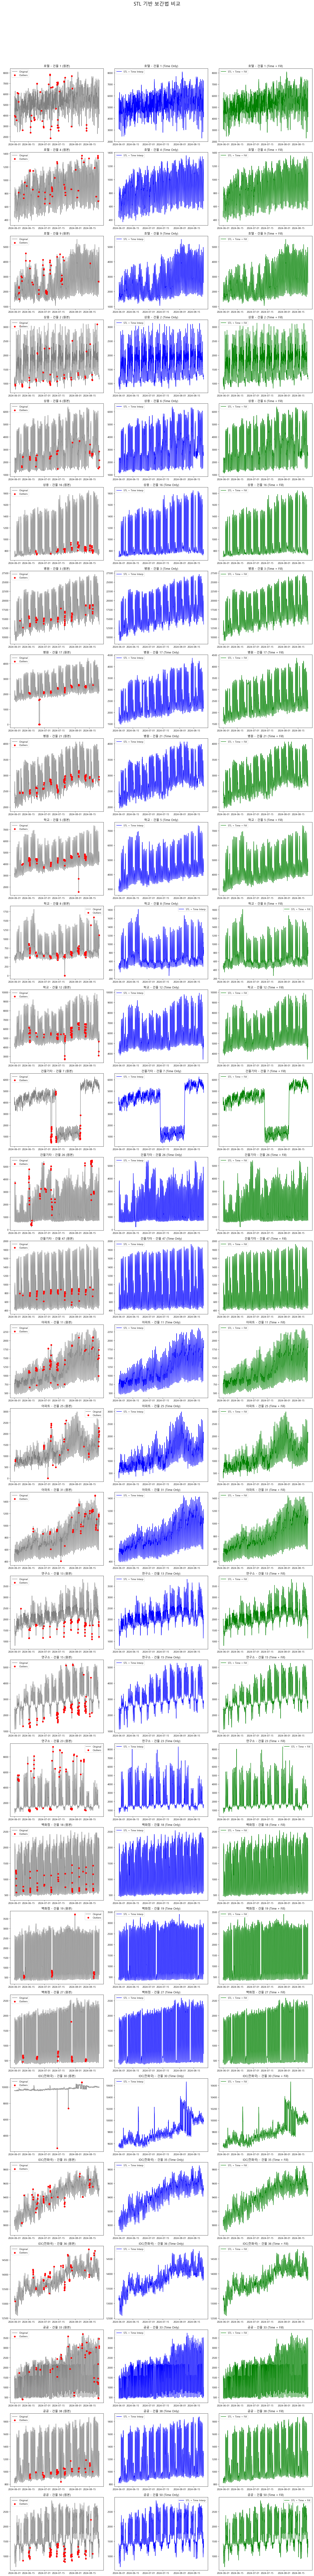

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# 1. 데이터 로드 및 병합
train = pd.read_csv('dataset/train.csv', encoding='utf-8')
bi = pd.read_csv('dataset/building_info.csv', encoding='utf-8')
merged_df = pd.merge(train, bi[['건물번호', '건물유형']], on='건물번호', how='left')
merged_df['전력소비량(kWh)'] = pd.to_numeric(merged_df['전력소비량(kWh)'], errors='coerce')
merged_df['일시'] = pd.to_datetime(merged_df['일시'], format='%Y%m%d %H', errors='coerce')

# 2. 건물유형별 보간
building_types = merged_df['건물유형'].dropna().unique()
all_time_only_dfs = {}
all_time_ffill_dfs = {}

for btype in building_types:
    type_df = merged_df[merged_df['건물유형'] == btype].copy()
    time_only_dfs = []
    time_ffill_dfs = []

    for bid, group in type_df.groupby('건물번호'):
        group = group.sort_values('일시').set_index('일시').asfreq('h')

        # 너무 결측이 많거나 데이터 부족하면 skip
        if group['전력소비량(kWh)'].isna().mean() > 0.2 or len(group) < 48:
            continue

        try:
            # STL 분해로 이상치 탐지
            stl = STL(group['전력소비량(kWh)'], period=24, robust=True)
            result = stl.fit()
            resid = result.resid
            threshold = 3 * resid.std()
            is_outlier = abs(resid) > threshold

            # 이상치 마스킹
            group['보간대상'] = group['전력소비량(kWh)'].copy()
            group.loc[is_outlier, '보간대상'] = np.nan

            # (A) 시간 기반 보간만
            A = group.copy()
            A['보간결과'] = A['보간대상'].interpolate(method='time')
            A = A.reset_index()
            A['건물번호'] = bid
            A['건물유형'] = btype
            time_only_dfs.append(A)

            # (B) 시간 + ffill + bfill
            B = group.copy()
            B['보간결과'] = B['보간대상'].interpolate(method='time').ffill().bfill()
            B = B.reset_index()
            B['건물번호'] = bid
            B['건물유형'] = btype
            time_ffill_dfs.append(B)

        except Exception:
            continue

    all_time_only_dfs[btype] = time_only_dfs
    all_time_ffill_dfs[btype] = time_ffill_dfs

# 3. 시각화 (각 건물유형당 최대 3개 건물)
fig_rows = sum(len(dfs[:3]) for dfs in all_time_only_dfs.values())
fig, axes = plt.subplots(fig_rows, 3, figsize=(18, 5 * fig_rows))
fig.suptitle("STL 기반 보간법 비교", fontsize=20)

row = 0
for btype in building_types:
    original_df = merged_df[merged_df['건물유형'] == btype]
    sample_dfs = all_time_only_dfs[btype][:3]
    sample_ffill_dfs = all_time_ffill_dfs[btype][:3]

    for i in range(len(sample_dfs)):
        bid = sample_dfs[i]['건물번호'].iloc[0]

        original = original_df[original_df['건물번호'] == bid].sort_values('일시')
        time_only = sample_dfs[i].sort_values('일시')
        time_ffill = sample_ffill_dfs[i].sort_values('일시')

        # STL 이상치 기준 마스킹
        original_stl = original.set_index('일시').asfreq('h')
        stl = STL(original_stl['전력소비량(kWh)'], period=24, robust=True).fit()
        resid = stl.resid
        threshold = 3 * resid.std()
        is_outlier = abs(resid) > threshold
        outlier_times = resid.index[is_outlier]

        # 시각화 - 이상치 scatter 시 안전하게
        axes[row, 0].plot(original['일시'], original['전력소비량(kWh)'], label='Original', color='gray')
        axes[row, 0].scatter(outlier_times, original_stl.loc[outlier_times, '전력소비량(kWh)'],
                     color='red', label='Outliers', zorder=3)
        axes[row, 0].set_title(f"{btype} - 건물 {bid} (원본)")
        axes[row, 0].legend()

        # 2. 시간 기반 보간
        axes[row, 1].plot(time_only['일시'], time_only['보간결과'], color='blue', label='STL + Time Interp')
        axes[row, 1].set_title(f"{btype} - 건물 {bid} (Time Only)")
        axes[row, 1].legend()

        # 3. 시간 + ffill + bfill
        axes[row, 2].plot(time_ffill['일시'], time_ffill['보간결과'], color='green', label='STL + Time + Fill')
        axes[row, 2].set_title(f"{btype} - 건물 {bid} (Time + Fill)")
        axes[row, 2].legend()

        row += 1

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
